In [1]:
import yt

/home/chris/src/yt_/yt_dev/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/chris/.config/yt/ytrc is deprecated in favor of /home/chris/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [7]:
ds = yt.load("Enzo_64/DD0043/data0043")

yt : [INFO     ] 2021-03-30 11:55:42,519 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2021-03-30 11:55:42,519 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2021-03-30 11:55:42,520 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-30 11:55:42,521 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-03-30 11:55:42,521 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-30 11:55:42,522 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2021-03-30 11:55:42,522 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2021-03-30 11:55:42,522 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2021-03-30 11:55:42,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-30 11:55:42,523 Parameters: hubble_constant           = 0.71


In [5]:
import yt
import numpy as np
sc = yt.visualization.volume_rendering.scene.Scene()
sc.add_camera()
pt = yt.visualization.volume_rendering.render_source.PointSource(np.array([[0.5,0.5,0.5]]))

<Camera Object>:
	position:[1. 1. 1.] unitary
	focus:[0. 0. 0.] unitary
	north_vector:[ 0.81649658 -0.40824829 -0.40824829]
	width:[1. 1. 1.] unitary
	light:None
	resolution:(512, 512)
Lens: <Lens Object>:
	lens_type:plane-parallel
	viewpoint:[-577350.55786476 -577350.55786476 -577350.55786476] unitary

In [6]:
sc.add_source(pt)

yup
hello


UnitParseError: Could not find unit symbol 'code_length' in the provided symbols.

<Scene Object>:
Sources: 
    source_00: <Point Source>
Camera: 
    <Camera Object>:
	position:[1. 1. 1.] unitary
	focus:[0. 0. 0.] unitary
	north_vector:[ 0.81649658 -0.40824829 -0.40824829]
	width:[1. 1. 1.] unitary
	light:None
	resolution:(512, 512)
Lens: <Lens Object>:
	lens_type:plane-parallel
	viewpoint:[-577350.55786476 -577350.55786476 -577350.55786476] unitary

In [72]:
# get a FRB 
xval = 0.5
slc = ds.slice(0,xval)

resolution = (300, 300)
frb = slc.to_frb(1, resolution)
    
#     dim_vals = [frb[dim] for dim in ['x', 'y', 'z']]
#     dim_vals[frb.axis] = np.full(dim_vals[frb.axis].shape, 
#                                  dim_vals[frb.axis].mean())
vals = frb[("gas","density")]


yt : [INFO     ] 2021-03-30 13:48:01,070 Making a fixed resolution buffer of (('gas', 'density')) 300 by 300


In [73]:
vals.shape

(300, 300)

In [52]:
# vals = vals[0:10,0:10]
# resolution = (10, 10)

In [74]:
z = np.linspace(0,ds.domain_width[2].to('code_length'),resolution[1])
y = np.linspace(0,ds.domain_width[1].to('code_length'),resolution[0])
x = np.full(z.shape,xval)

In [107]:
# try just a subset this time
Nmax = 310
Ny = resolution[0]
Nz = resolution[1]
dy = y[1] - y[0]
dz = z[1] - z[0]
dxeps = 1e-10 * dy
dxeps_array = np.array((dxeps, 0, 0))
# loop over elements
# vert/element convention
#   0 ---- 1 ---- 2 ---- 3
#   |      |      |      |
#   |  0   |   1  |   2  |
#   |      |      |      |
#  300 -- 301 -- 302 -- 303
#
# all_verts = []
all_vals = []

connectivity = []
Yg, Zg = np.meshgrid(y,z)
Yg = Yg.ravel()
Zg = Zg.ravel()
NyNz = Yg.size

Xg = ds.arr(np.full(Yg.shape, xval),"code_length")

Yg = np.concatenate([Yg, Yg])
Zg = np.concatenate([Zg, Zg])
Xg = np.concatenate([Xg, Xg+dxeps])
dxN = np.array((NyNz, 0 ,0),dtype='int')
verts = ds.arr(np.column_stack([Xg, Yg, Zg]),"code_length")

for i in range(0,NyNz):
    
    row = int(np.floor((i+1)/(Ny)))
    col = i - row * (Ny-1) 
    
    if col + 1 < Ny and row +1 < Nz:
#         print((i,col,row))

        # values of the 4 nodes
        top_left = np.float64(vals[col,row].value)
        top_left_ijk = i
    #     top_left_xyz = np.array((xval, y[col], z[row])    )

        top_right = np.float64(vals[col+1,row].value)
    #     top_right_xyz = np.array((xval, y[col+1], z[row]))
        top_right_ijk = i+1

        bot_right = np.float64(vals[col+1,row+1].value)
    #     bot_right_xyz = np.array((xval, y[col+1], z[row+1]))
        bot_right_ijk = i+Ny+1

        bot_left = np.float64(vals[col,row+1].value)
    #     bot_left_xyz = np.array((xval, y[col], z[row+1]))
        bot_left_ijk = i + Ny

        connectivity.append([
            top_left_ijk,
            top_right_ijk,
            bot_right_ijk,
            bot_left_ijk,
            top_left_ijk+NyNz,
            top_right_ijk+NyNz,
            bot_right_ijk+NyNz,
            bot_left_ijk+NyNz,
        ])
        # simulate an 8-node hexahedral with a tiny displacement in the slice-axis
    #     all_verts.append((
    #         top_left_xyz,
    #         top_right_xyz,
    #         bot_right_xyz,
    #         bot_left_xyz,
    #         top_left_xyz+dxeps_array,
    #         top_right_xyz+dxeps_array,
    #         bot_right_xyz+dxeps_array,
    #         bot_left_xyz+dxeps_array,    
    #     ))

        all_vals.append(
            [top_left,
            top_right,
            bot_right,
            bot_left,
            top_left,
            top_right,
            bot_right,
            bot_left, ]       
        )

all_vals = np.array(all_vals)
connectivity = np.array(connectivity)


In [110]:
connectivity.shape

(45148, 8)

In [111]:
verts.shape

(180000, 3)

In [109]:
all_vals.shape

(45148, 8)

In [95]:
bvh = yt.utilities.lib.bounding_volume_hierarchy.BVH(verts,connectivity,all_vals)

# BVH(vertices, indices, field_data)

TypeError: a bytes-like object is required, not 'list'

In [122]:
data = {('connect1','slicevals'): np.log10(all_vals)}

ds_u = yt.load_unstructured_mesh(connectivity, verts, node_data=data)

yt : [INFO     ] 2021-03-30 14:01:58,913 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-03-30 14:01:58,914 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-03-30 14:01:58,914 Parameters: domain_left_edge          = [0.45 0.   0.  ]
yt : [INFO     ] 2021-03-30 14:01:58,915 Parameters: domain_right_edge         = [0.55 1.1  1.1 ]
yt : [INFO     ] 2021-03-30 14:01:58,915 Parameters: cosmological_simulation   = 0.0


In [88]:
sc = 

array([[     0,      1,    301, ...,  90001,  90301,  90300],
       [     1,      2,    302, ...,  90002,  90302,  90301],
       [     2,      3,    303, ...,  90003,  90303,  90302],
       ...,
       [ 89101,  89102,  89402, ..., 179102, 179402, 179401],
       [ 89399,  89400,  89700, ..., 179400, 179700, 179699],
       [ 89400,  89401,  89701, ..., 179401, 179701, 179700]])

In [113]:
yt.load_unstructured_mesh?

yt : [INFO     ] 2021-03-30 14:04:53,992 Setting default field to ('connect1', 'slicevals')
yt : [INFO     ] 2021-03-30 14:04:54,238 Rendering scene (Can take a while).


yup
wtf yo


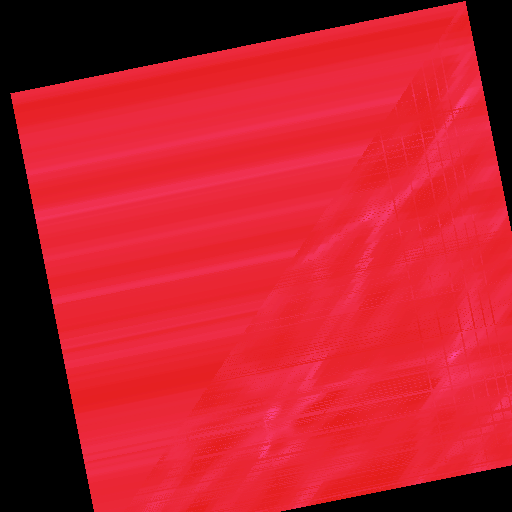

In [128]:
slice_scene = yt.create_scene(ds_u)
slice_scene.add_camera()
cam = slice_scene.get_camera()
cam.set_position((-1,0.5,0.5),north_vector=(0,0,1))
cam.set_focus((xval,0.5,0.5))
slice_scene.render()
slice_scene.show()

In [118]:
res = slice_scene.render()


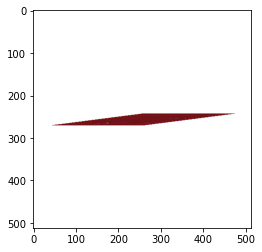

In [120]:
import matplotlib.pyplot as plt
plt.imshow(res)